# Curbing Chicago Car Crashes

**Authors:** Carlos McCrum, Michael Lee, Doug Mill
***

## Overview

Our task is to build inferential classification models for the Vehicle Safety Board of Chicago. We cleaned and formatted our data provided by the City of Chicago containing crashes,  vehicles and people relating to crashes from 2016 to 2020, we then modeled the primary contributory causes of car accidents into two categories. We used an iterative modeling approach and incorporated several classification models to see if we could find what crashes were preventable. Our recommendations include investing in driver education for certain age groups and fixing certain road conditions that could cause a crash. 
***

## Business Problem

Vehicle Safety Board wants to know if they should spend more funding in drivers education or fixing roads. Determining whether a crash is preventable and how to allocate funds to limit the number of crashes to present to the Vehicle Safety Board of Chicago.


***

## Data Understanding

Our stakeholder is the Vehicle Safety Board of Chicago. They are launching a new campaign to reduce car crashes. Our task is to build an inferential model to find out  which crashes were preventable and not. We labeled ‘Preventable’ as crashes that could have easily been avoided. Not following traffic laws and negligent driving would fall under this category. ‘Less Preventable’ are crashes that would require a substantial amount of money, time, and labor to fix. Bad road conditions, vision obscurity, and bad weather conditions would fall under this category.
***

##### Start by importing necessary packages. 

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import plot_confusion_matrix, roc_auc_score, plot_roc_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

***

## Model Preparation

Import data previously cleaned with only the relevant columns we need for our analysis. Our variable is a binary target that points to the contributory cause of the crash either being preventable or non-preventable.

***


Import our cleaned dataframe we cleaned previously. 

In [17]:
main_df = pd.read_csv('data/cleaned_data/cleaned_modeling_data.csv')
columns_to_drop = ['Unnamed: 0']
main_df.drop((columns_to_drop), axis = 1, inplace = True)

Check to see if we have a class imbalance. 

In [18]:
main_df['Target'].value_counts(normalize = True)

0    0.754374
1    0.245626
Name: Target, dtype: float64

Check correlations with our target


## Data Modeling
We modeled the data through iterative modeling. We used a logistic regression model as our first simple model. For our second model, we created a Decision Tree Classifier that scored slightly better than our simple model. We used a RFE to determine the most important features and iterated with GridSearch to find the best parameters. Lastly, we used a XGBoost classifier with GridSearchCV to find the best model.
***

## Simple Model - Logistic Regression

To measure our model performance, we will be using accruacy. 
Since we are creating a inferential model, correctly classifiying the target category correctly, should be the main priority.

To run our first simple model we start off by dropping irrelevant columns. 

In [19]:
columns_to_drop = ['CRASH_RECORD_ID','CRASH_DATE', 'LONGITUDE', 'LATITUDE', 'Target']

Split our data with train test split 

In [20]:
X = main_df.drop((columns_to_drop), axis=1)
y = main_df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [21]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [22]:
print(logreg.coef_, logreg.intercept_)

[[ 0.12988649  0.20098016  0.822363    1.42466443 -0.44294368 -0.07022554
   0.45626927 -0.40778448  0.90737109 -2.07794228]] [-0.69633504]


In [23]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
X = add_constant(X)
print(Logit(y, X).fit().summary())

Optimization terminated successfully.
         Current function value: 0.481552
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 Target   No. Observations:               952140
Model:                          Logit   Df Residuals:                   952129
Method:                           MLE   Df Model:                           10
Date:                Wed, 27 Oct 2021   Pseudo R-squ.:                  0.1362
Time:                        12:36:34   Log-Likelihood:            -4.5851e+05
converged:                       True   LL-Null:                   -5.3080e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.6939      0.005   -143.200      0.000      -0.703      

Based on the coefficients generated from our model, it seems like 'Defect_Road' has the highest odds of happening at around 3x when compared to other factors.

This means that we can cut down on the impact of 'Defect_Roads' to mitigate crashes. So, perhaps some funding in road fixtures would be a good idea.

In [24]:
logreg.score(X_test, y_test)

0.7466465015648959

Our model seems to be pretty good at classifying if a crash was easily preventable or less preventable. However, we wanted to explore if a DecisionTreeClassifier or XGBoost would give us a better accuracy score.

## Using RFE to select the most important columns

In order to determine the most important features, we used the RFE tool with the DecisionTreeClassifier

In [25]:
# Instantiate classifier and parameters for model accessibility
dt = DecisionTreeClassifier()
num_features_to_select = 5

select = RFE(dt, n_features_to_select=num_features_to_select)
select.fit(X = X_train, y = y_train)

# Create a list of the most important features
keep_list = [(k,v) for k,v in zip(main_df.drop((columns_to_drop), axis=1).columns,select.support_)]
keep_string = "'"
for k,v in keep_list:
    if v:
        keep_string += k + "','"
keep_string = keep_string[:-2]

keep_string

"'BAD_ROAD_CONDITION','DEFECT_ROAD','WORKING_TRAFFIC_DEVICE','OBSCURED_VIZ','DRIVER_ERROR'"

In [26]:
X = main_df[['BAD_VISIBILITY','BAD_TRAFFIC','BAD_ROAD_CONDITION','DEFECT_ROAD','WORKING_TRAFFIC_DEVICE']]
y = main_df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

dt_rfe = DecisionTreeClassifier(random_state = 42)
dt_rfe.fit(X_train, y_train)
dt_rfe.score(X_test, y_test)

0.7549478017938538

In [27]:
X = main_df.drop((columns_to_drop), axis = 1)
y = main_df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

dt = DecisionTreeClassifier(random_state = 42)
dt.fit(X_train, y_train)
dt.score(X_test, y_test)

0.7563467557291995

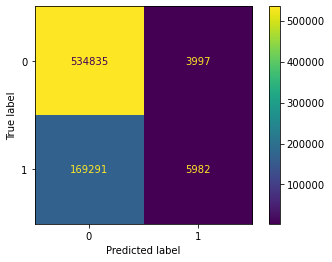

In [28]:
plot_confusion_matrix(dt, X_train, y_train);

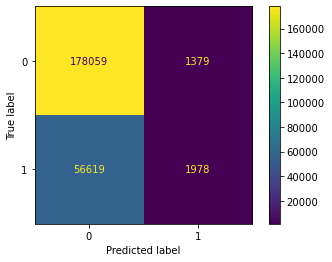

In [29]:
plot_confusion_matrix(dt, X_test, y_test);

Awsome! Our DecisionTreeClassifier is doing better than the LogisticRegression model. However, it does not seem to be by much. Lets see if we can find the best parameters for the DecisionTreeClassifier using GridSearch

# Grid Search

Because Decision Trees gave us the best accuracy score, we decided to try and find the best parameters
Using Grid Search to find the best parameters

In [30]:
# Look through max depth, min samples split, min sample leaf to find the best perameters. 
grid = [{'max_depth': [4, 6, 8], 
         'min_samples_split': [5, 10, 15], 
         'min_samples_leaf': [20, 25, 30]}]
GS = GridSearchCV(estimator=dt, 
                          param_grid=grid, 
                          scoring='accuracy', 
                          cv=5)

Fit to our grid
- Analyze the results
- See what the best perameters are
- Find our best score


In [31]:
GS.fit(X_train, y_train)
GS.cv_results_

{'mean_fit_time': array([0.25202775, 0.24564681, 0.24205537, 0.23427987, 0.23557801,
        0.2353734 , 0.23527226, 0.23541002, 0.2353765 , 0.30598264,
        0.30469394, 0.30410395, 0.30390573, 0.30273643, 0.30359397,
        0.31187563, 0.3033432 , 0.34189277, 0.35214505, 0.35195127,
        0.35458512, 0.351373  , 0.351371  , 0.35091228, 0.35046878,
        0.35166516, 0.35316916]),
 'std_fit_time': array([0.0154109 , 0.01873293, 0.0131987 , 0.00110857, 0.0009769 ,
        0.00151287, 0.00111   , 0.00292   , 0.00151185, 0.00330171,
        0.00320466, 0.0030263 , 0.00303338, 0.00147146, 0.00392192,
        0.01899246, 0.0012062 , 0.03694009, 0.00389209, 0.00294125,
        0.00193597, 0.00241225, 0.00150143, 0.00224246, 0.00434422,
        0.00390952, 0.0033605 ]),
 'mean_score_time': array([0.01795106, 0.01705537, 0.0167542 , 0.01705542, 0.01695423,
        0.0165555 , 0.01695471, 0.01665654, 0.01695399, 0.01755261,
        0.01805696, 0.01695442, 0.01727257, 0.01735306, 0.017353

In [32]:
GS.best_params_

{'max_depth': 6, 'min_samples_leaf': 25, 'min_samples_split': 5}

In [33]:
GS.best_estimator_.score(X_test, y_test)

0.7562291259688702

The Grid Search gave us the optimal parameters for the DecisionTreeClassifier, and it seems to do slightly better than the DecisionTree with default parameters.

## XGBoost

- Initiate XGBClassifier, fit, and determine the training and validation scores. 

In [34]:
clf = XGBClassifier(eval_metric='mlogloss')
clf.fit(X_train, y_train)
training_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

# Accuracy
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))
print('Test Accuracy: {}')

Training Accuracy: 75.73%
Validation accuracy: 75.64%
Test Accuracy: {}


In [35]:
clf.score(X_test, y_test)

0.7563929674207575

In [36]:
# Test different parameters 
param_grid = {
    'learning_rate': [0.2, 0.5],
    'max_depth': [6],
    'min_child_weight': [1],
    'subsample': [0.7],
    'n_estimators': [100, 200],
}

In [37]:
# Utilitze GridSearch to find best parameters
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
test_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.2
max_depth: 6
min_child_weight: 1
n_estimators: 200
subsample: 0.7

Training Accuracy: 75.73%
Validation accuracy: 75.64%


In [38]:
grid_clf.score(X_test, y_test)

0.7563845652950196

Well, that model took long to run, but we seem to have a winner. Based on the accuracy scores of our models, the XGBoost performs the best.

## Results

The results of our model indicated that most of the crashes were Preventable. By spending more money on drivers education in ages 20 - 39, we could curb the total accidents in Chicago drastically.

## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions

We recommend investing in online drivers education because this could significantly lower the amount of preventable crashes in the Chicago area. We recommend driver education because it is affordable, easy to implement, and saves a lot more in labor costs vs. repairing all the roads in Chicago.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***